## Introduction

In this deep learning project, an initiative has been undertaken to develop a machine learning model and accompanying code for the purpose of quantifying the number of Capuchin bird calls within given audio clips.

The provided dataset encompasses a training set consisting of short audio clips (3-5 seconds in duration), containing instances of Capuchin bird calls (positive examples), as well as other short audio clips of the same duration that lack Capuchin bird calls (negative examples). Additionally, a testing set is provided, comprising longer forest audio files (3-6 minutes in duration), where the objective is to determine the count of Capuchin bird calls.

The project methodology unfolds with the conversion of all training set audio files into spectrogram images, serving as the foundation for training a Convolutional Neural Network (CNN) image classification model. This model is engineered to ascertain the presence or absence of Capuchin bird calls within an audio file. Subsequently, attention is directed towards the testing set—specifically, the longer audio files. These are segmented into smaller audio slices, each spanning 3-5 seconds, and subjected to predictions regarding the presence of Capuchin bird calls utilizing the pre-trained CNN classification model. To obtain the total count of Capuchin bird calls, the prediction values for individual audio slices within a given file are aggregated through summation, culminating in the derivation of the final count.

This project endeavors to contribute to the field of automated bioacoustic analysis by offering an effective solution for the identification and enumeration of Capuchin bird calls in larger audio recordings.

## Data Description

The provided dataset is organized into three distinct folders, each contributing unique audio clips tailored for specific aspects of the project:

  1. `Forest Recordings`:
        This folder is designated for the prediction of bird call counts and serves as the test dataset.
        Contains long audio clips ranging from 3 to 6 minutes in duration.
        The objective is to produce the final prediction for the presence of Capuchin bird calls within these extended audio recordings.
        This section of the dataset serves as the benchmark against which the developed model's efficacy will be evaluated.

  2. `Parsed_Capuchinbird_Clips`:
        Constituting a crucial segment of the training set, this folder comprises short audio clips lasting 3 to 5 seconds.
        These clips are characterized by the inclusion of Capuchin bird calls, thereby functioning as positive examples for the machine learning model.
        The distinctive feature of Capuchin bird calls within this subset facilitates the training process, enabling the model to learn and identify the relevant acoustic patterns associated with Capuchin presence.

  3. `Parsed_Not_Capuchinbird_Clips`:
        Also integral to the training set, this folder encompasses short audio clips spanning 3 to 5 seconds each.
        In contrast to the previous category, these clips serve as negative examples, devoid of Capuchin bird calls.
        The absence of Capuchin bird calls in this subset aids the model in discerning features that distinguish between instances with and without Capuchin bird calls, contributing to a robust classification framework.

This well-structured dataset is designed to facilitate the training and evaluation of a machine learning model, fostering the development of an effective system for the automated identification and enumeration of Capuchin bird calls within audio recordings.

## 1. Import and Install Dependencies

### 1.1 Install Dependencies

In [2]:
!pip uninstall tensorflow
!pip install tensorflow==2.8.0 tensorflow-io==0.25.0 matplotlib

Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.14.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.14.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 113.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

### 1.2 Load Dependencies

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
from scipy.stats import norm

## 2. Build Data Loading Function

The `load_wav_16k_mono` function is designed to convert a waveform audio clip into a tensor format, ensuring a mono-channel representation and a standardized sampling rate of 16 kHz. This function streamlines audio preprocessing, providing a fundamental tool for preparing data for subsequent analysis and model training within the project.

### 2.1 Define Paths to FIles

In [2]:
# For the purpose of the project, I imported the file from my google drive while using google colab.
# I have added the dataset file 'yahoo_dataset.csv' in the github repo.
# Please access that file as you will not have access to my drive.
# However, if you still wish to access the file from your google drive, then
# you can execute the following code on google colab signed into the same account
# as the google drive that you wish to access.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
drive_path = '/content/drive/My Drive'

In [4]:
CAPUCHIN_FILE = os.path.join(drive_path, 'data', 'Parsed_Capuchinbird_Clips', 'XC3776-0.wav')
NOT_CAPUCHIN_FILE = os.path.join(drive_path, 'data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

### 2.2 Build Dataloading Function

In [5]:
def load_wav_16k_mono(audiofile):
    # Load encoded wav file
    file_contents = tf.io.read_file(audiofile)
    # Decode wav
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Remove trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample audio amplitude from 44100Hz to 16000Hz (16kHz)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

### 2.3  Plot Wave

In [6]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

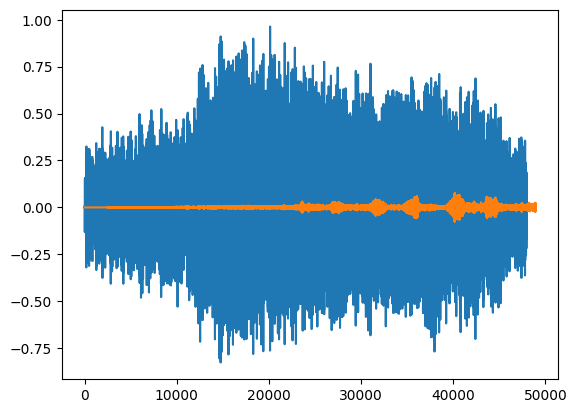

In [7]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## 3. Create the tensorflow dataset

### 3.1 Define Paths to Positive and Negative data

In [106]:
POS = os.path.join(drive_path, 'data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join(drive_path, 'data', 'Parsed_Not_Capuchinbird_Clips')

### 3.2 Create Tensorflow Datasets

In [107]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

### 3.3 Add Labels and Combine Positive and Negative Samples

In [108]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

## 4. Determine Average Length of a Capuchin Call

### 4.1 Calculate Wave Cycle Length

In [109]:
lengths = []
for file in os.listdir(POS):
  wave = load_wav_16k_mono(os.path.join(POS, file))
  lengths.append(len(wave))

### 4.2 Calculate Mean, Min, and Max

In [110]:
mean = tf.math.reduce_mean(lengths)
min = tf.math.reduce_min(lengths)
max = tf.math.reduce_max(lengths)
print("Average Length of a Capuchin Call:", mean)
print("Length of Shortest Capuchin Call:", min)
print("Length of Longest Capuchin Call:", max)

Average Length of a Capuchin Call: tf.Tensor(54156, shape=(), dtype=int32)
Length of Shortest Capuchin Call: tf.Tensor(32000, shape=(), dtype=int32)
Length of Longest Capuchin Call: tf.Tensor(80000, shape=(), dtype=int32)


## 5. Build Preprocessing Function to Convert Wavefile to a Spectogram

The `preprocess` function orchestrates essential steps in audio data preparation by seamlessly integrating the `load_wav_16k_mono` function. This versatile function first employs `load_wav_16k_mono` to convert a waveform audio clip into a tensor, ensuring a mono-channel format and a standardized 16 kHz sampling rate. Subsequently, the function enforces a fixed duration of 3 seconds (equivalent to 48,000 frames) for the audio clip. The culmination of these preprocessing steps results in the generation of a spectrogram—a visual representation of the audio signal's frequency content. This function serves as a pivotal component in the larger workflow, providing a streamlined approach to transform raw audio data into a format conducive to further analysis and model training.

### 5.1 Build Preprocessing Function

In [111]:
def preprocess(audio_file, label):
  wav = load_wav_16k_mono(audio_file)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)
  spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis=2)
  return spectogram, label

In [112]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)
wav = wav[:48000]
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav], 0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 1.0432389e-06, -3.0215922e-06,  1.9820709e-06, ...,
       -4.5542806e-02, -5.4887902e-02, -8.5778177e-02], dtype=float32)>

### 5.2 Test Out the Function and Viz the Spectogram

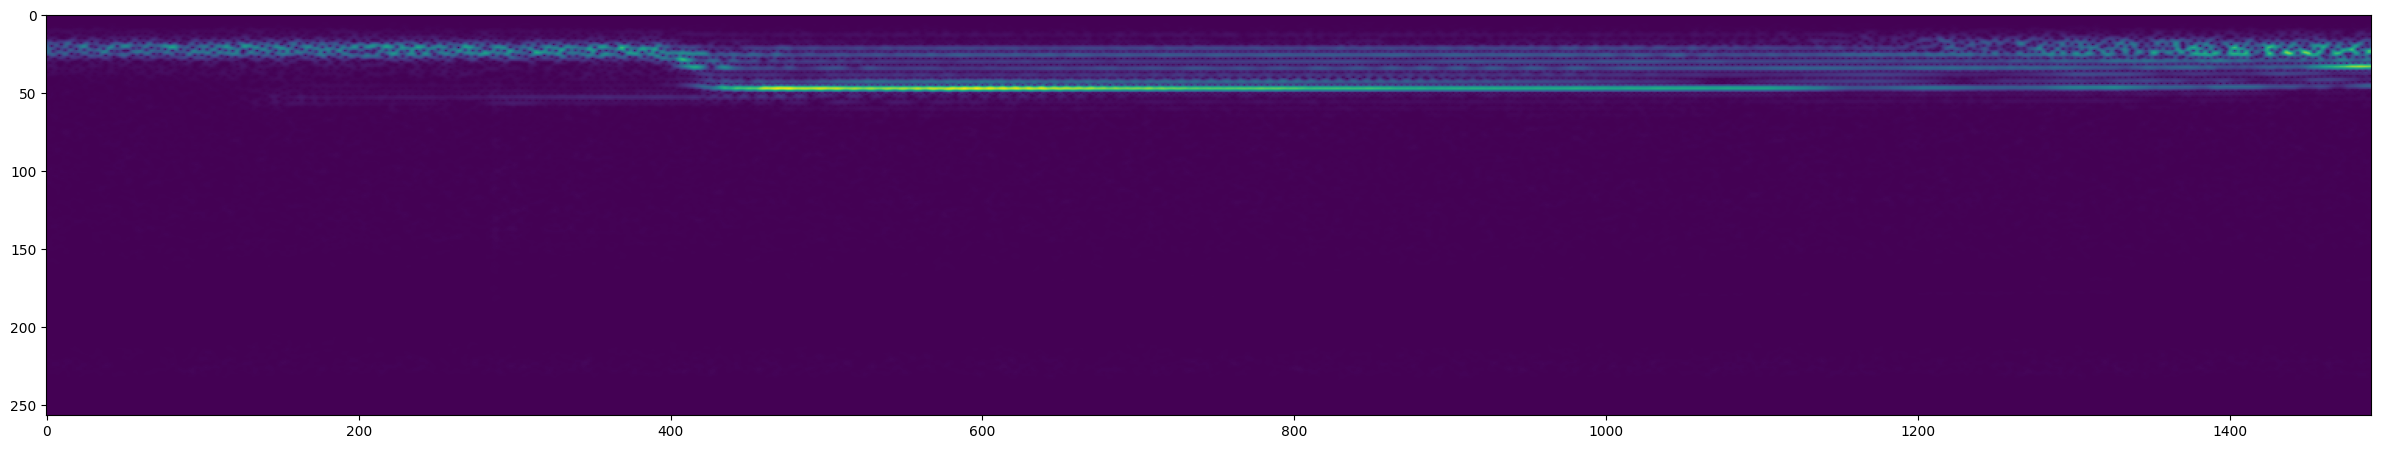

In [113]:
audio_file, label = positives.shuffle(buffer_size=100).as_numpy_iterator().next()
spectogram, label = preprocess(audio_file, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

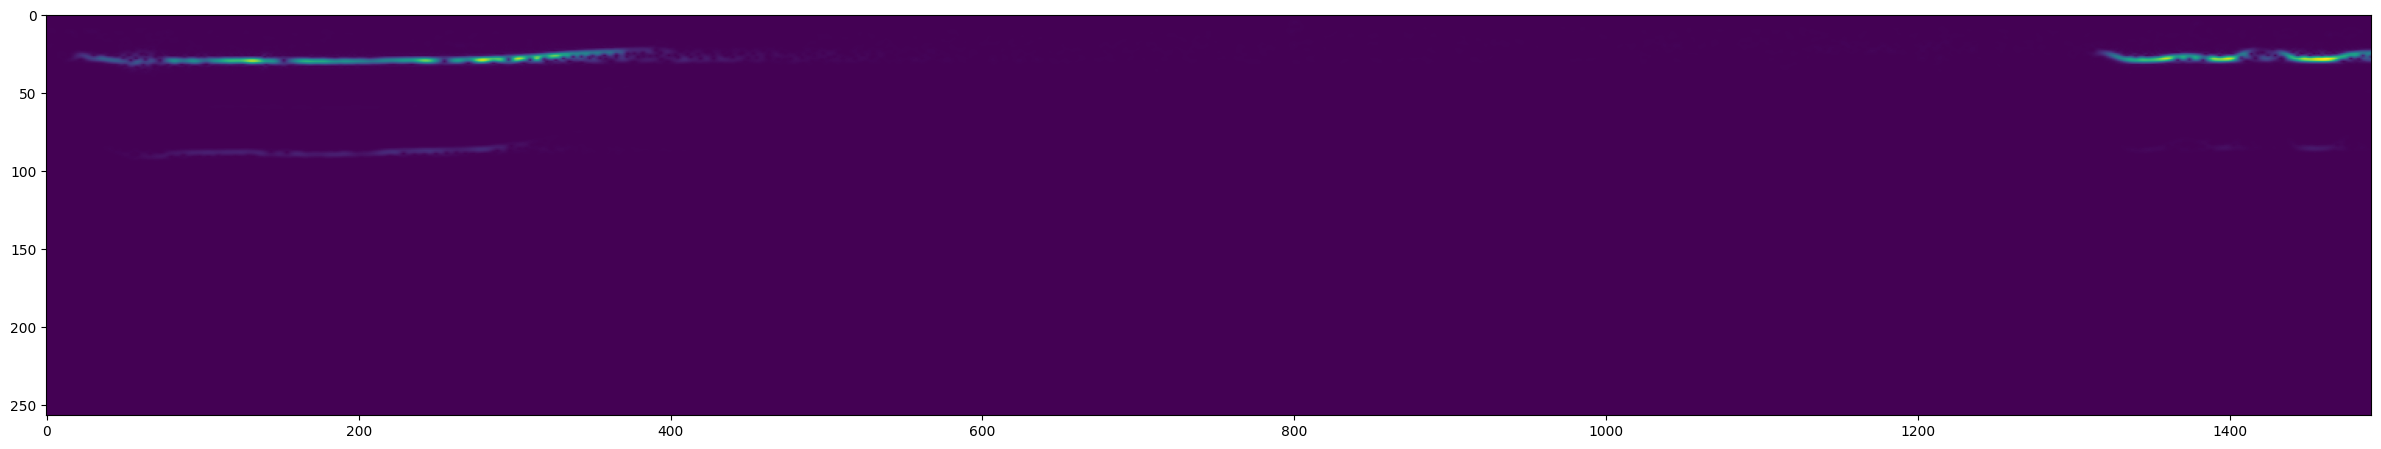

In [114]:
audio_file, label = negatives.shuffle(buffer_size=100).as_numpy_iterator().next()
spectogram, label = preprocess(audio_file, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

## 6. Create Training and Testing Partitions

### 6.1 Create a Tensorflow Data Pipeline

In [115]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

### 6.2 Split into Training and Testing Partitions

In [116]:
train = data.take(36)
test = data.skip(36).take(15)

### 6.3 Test One Batch

In [133]:
samples, label = train.as_numpy_iterator().next()

In [134]:
samples.shape

(16, 1491, 257, 1)

## 7. Build Deep Learning Model

Within this section, a  classification model is crafted for the task at hand. The model comprises two `Conv2D` layers, strategically incorporated to extract relevant features from the spectrogram representations. Following this, a `MaxPool2D` layer is employed for spatial down-sampling, enhancing the model's ability to discern salient patterns. The `Flatten` layer serves as a pivotal step, preparing the extracted features for input into a `Dense` layer, which contributes to the model's ability to capture complex relationships within the data. The inclusion of a `Dropout` layer adds a regularization element, mitigating the risk of overfitting during training. Finally, the output layer is designed to yield predictions, completing the architecture of this classification model.

### 7.1 Load Tensorflow Dependencies

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

### 7.2 Build the CNN Model, Compile, and View Summary

In [119]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 conv2d_5 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 495, 84, 16)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 665280)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               85155968  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

In [120]:
opt = Adam(learning_rate=1e-4)
loss = BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=[Recall(), Precision()])

### 7.3 FIt Model, View Loss and KPI Plots

In [121]:
hist = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
36/36 [==============================] - 8s 189ms/step - loss: 0.4596 - recall_2: 0.8940 - precision_2: 0.7759 - val_loss: 0.0299 - val_recall_2: 0.9846 - val_precision_2: 1.0000
Epoch 2/5
36/36 [==============================] - 6s 169ms/step - loss: 0.0774 - recall_2: 0.9864 - precision_2: 0.9797 - val_loss: 0.0113 - val_recall_2: 0.9851 - val_precision_2: 1.0000
Epoch 3/5
36/36 [==============================] - 6s 176ms/step - loss: 0.0207 - recall_2: 0.9868 - precision_2: 0.9933 - val_loss: 0.0267 - val_recall_2: 0.9545 - val_precision_2: 1.0000
Epoch 4/5
36/36 [==============================] - 6s 169ms/step - loss: 0.0081 - recall_2: 0.9932 - precision_2: 1.0000 - val_loss: 0.0027 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 5/5
36/36 [==============================] - 7s 184ms/step - loss: 0.0050 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 0.0048 - val_recall_2: 1.0000 - val_precision_2: 1.0000


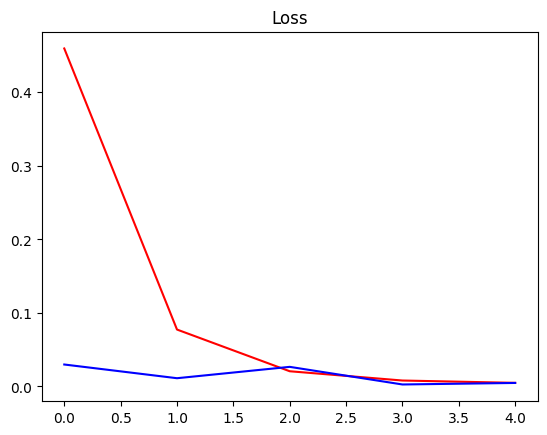

In [122]:
plt.title("Loss")
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

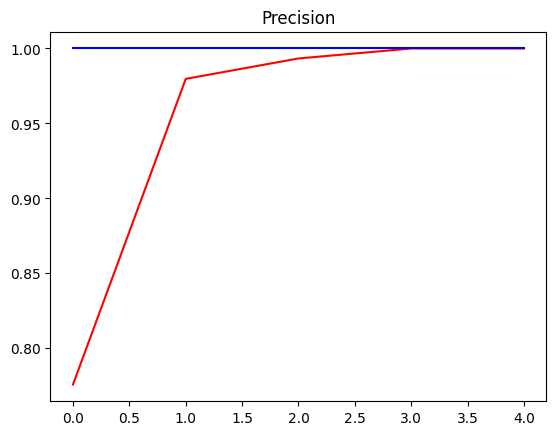

In [124]:
plt.title("Precision")
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

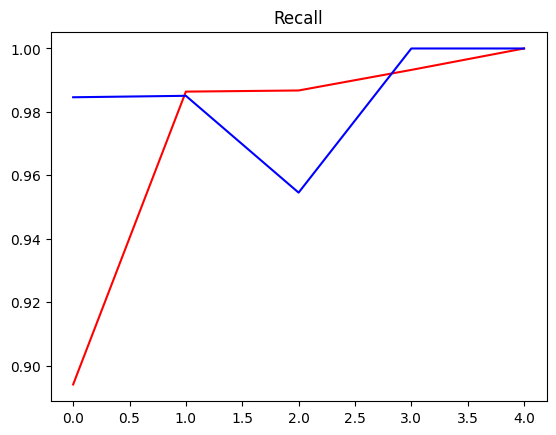

In [125]:
plt.title("Recall")
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

## 8. Make a Prediction on a Single Clip

### 8.1 Get One Batch and make a Prediction

In [41]:
X_test, y_test = test.as_numpy_iterator().next()
y_hat = model.predict(X_test)

### 8.2 Convert Logits into Classes

In [46]:
y_hat = [1 if pred > 0.5 else 0 for pred in y_hat]

## 9. Build Forest Testing Functions

The `load_mp3_16k_mono` function is tailored to preprocess audio data encoded in the MP3 format, mirroring the functionality of the `load_wav_16k_mono` function. This versatile function accepts an MP3 file as input, executing the necessary steps to convert the audio into a tensor with a mono-channel representation and a standardized sampling rate of 16 kHz.

### 9.1 Load up MP3s

In [51]:
"""Load a WAV file, convert it to a float tensor, and resample it to 16 kHz single-channel audio file"""
def load_mp3_16k_mono(audio_file):
  res = tfio.audio.AudioIOTensor(audio_file)
  # Convert to tensor and combine channels
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1) / 2
  # Extract sample rate and cast to int
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Resample to 16 kHz
  wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
  return wav

In [53]:
mp3 = os.path.join(drive_path, 'data', 'Forest Recordings', 'recording_00.mp3')
wav = load_mp3_16k_mono(mp3)
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
       -1.1291276e-02, -1.4230422e-02, -3.0555837e-03], dtype=float32)>

In [56]:
# Slice the audio file into smaller audio clips of 3 seconds each
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
sample, index = audio_slices.as_numpy_iterator().next()

### 9.2 Build Function to Convert Clips into Windowed Spectograms

In [59]:
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding, sample], 0)
  spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis=2)
  return spectogram

### 9.3 Convert Longer Clips into Windows and Make Predictions

In [83]:
audio_slices =  tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [84]:
y_hat = model.predict(audio_slices)
y_hat = [1 if pred > 0.99 else 0 for pred in y_hat]

### 9.4 Group Consecutive Detections

In [86]:
from itertools import groupby

In [90]:
y_hat = [key for key, group in groupby(y_hat)]
calls = tf.math.reduce_sum(y_hat).numpy()
print("Capuchin bird calls:", calls)

Capuchin bird calls: 5


## 10. Make Predictions

### 10.1 Loop over all recordings and make predictions

In [126]:
results = {}
for file in os.listdir(os.path.join(drive_path, 'data', 'Forest Recordings')):
  AUDIO_FILE = os.path.join(drive_path, 'data', 'Forest Recordings', file)

  wav = load_mp3_16k_mono(AUDIO_FILE)
  audio_slices =  tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  y_hat = model.predict(audio_slices)
  results[file] = y_hat

### 10.2 Convert Predictions into Classes

In [127]:
class_preds = {}
for file, logits in results.items():
  class_preds[file] = [1 if pred > 0.99 else 0 for pred in logits]

### 10.3 Group Consecutive Predictions

In [128]:
calls_per_record = {}
for file, preds in class_preds.items():
  calls_per_record[file] = tf.math.reduce_sum([key for key, group in groupby(preds)]).numpy()

In [129]:
calls_per_record

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 2,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 2,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 16,
 'recording_27.mp3': 0,
 'recording_26.mp3': 2,
 'recording_28.mp3': 15,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_35.mp3': 0,
 'recording_34.mp3': 4,
 'recording_33.mp3': 0,
 'recording_36.mp3': 0,
 'recording_38.mp3': 1,
 'recording_37.mp3': 3,
 'recording_40.mp3': 1,
 'recording_39.mp3': 14,
 'recording_

## 11. Export Results

In [130]:
import csv

In [132]:
with open('results.csv', 'w', newline='') as f:
  writer = csv.writer(f, delimiter=',')
  writer.writerow(['recording', 'capuchin_calls'])
  for key, value in calls_per_record.items():
    writer.writerow([key, value])

## Conclusion

The achieved recall and precision values of 1.0 for both the training and validation sets underscore the remarkable effectiveness of the developed classification model in accurately identifying Capuchin bird calls within short audio clips. These exceptional performance metrics on the training and validation data suggest that the model has successfully learned discriminative features, generalizing well to previously unseen examples during validation.

Analyzing the exported results in the CSV file will shed light on the model's ability to generalize to larger, more complex datasets. Potential challenges may include handling background noise, variations in bird call patterns, and other acoustic complexities inherent in forest recordings.

In conclusion, the project has successfully demonstrated the development of an effective machine learning model for Capuchin bird call identification, showcasing outstanding performance on training and validation data. The exported results from the testing set provide a valuable foundation for further refinement and potential enhancements to address challenges associated with real-world forest recordings. Ongoing efforts to iteratively improve the model's robustness and adaptability will contribute to its eventual deployment in bioacoustic analysis applications, affirming its potential significance in the broader field of automated wildlife sound recognition.
